In [ ]:
import pandas as pd
data = pd.read_csv("logvideo_20201013.csv")


In [ ]:
data.head(3)

,post_id,user_id,owner_id,event_id,timestamp,title,link
0,770bb557c1ecf8e904b82b6d98fe781d,8c5f625a822f21f1bb61677af47e86a6,50addce2b62ccb9454129b7ee1148a87,1002,1601401792,[KPOP IN PUBLIC CHALLENGE] SuperM 슈퍼엠 ‘Jopping...,https://15245293302644799.lotuscdn.vn/12119819...
1,c5534e7913255504db3fd94f6ae779c8,85e766a8037584eda1113a472293e1fb,794c173fb2cfc29665b0af776a172d39,1002,1601436640,Clip người đàn ông tung cú đấm trời giáng vào ...,https://10541184629469490.lotuscdn.vn/12119696...
2,9cbaf2ba4b710f961ebc238eb9282729,e08d1d35b5f039e471599a2ef50e38b0,0e8614ac686b68f692530cb81b53947e,1002,1601436672,Chồng quần quật làm việc nhưng xem chừng cô vợ...,https://10538870372954177.lotuscdn.vn/12119787...


In [ ]:
print(len(data.post_id.unique()),len(data.user_id.unique()),len(data.event_id.unique()),len(data.link.unique()))

53959 115191 16 47261


In [ ]:
data=data.set_index(['user_id','timestamp']).sort_index()
data =data.reset_index()

In [ ]:
user_ids = data["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

post_ids = data["post_id"].unique().tolist()
post2post_encoded = {x: i for i, x in enumerate(post_ids)}
post_encoded2post = {i: x for i, x in enumerate(post_ids)}

title_ids = data["title"].unique().tolist()
title2title_encoded = pickle.load( open("title.pkl", "rb"))
# title2title_encoded = {x: i for i, x in enumerate(title_ids)}
# title_encoded2title = {i: x for i, x in enumerate(title_ids)}

link_ids = data["link"].unique().tolist()

import pickle
link2link_encoded = pickle.load( open("link.pkl", "rb"))
# link2link_encoded = {x: i for i, x in enumerate(link_ids)}
# link_encoded2link = {i: x for i, x in enumerate(link_ids)}



owner_ids = data["owner_id"].unique().tolist()
owner2owner_encoded = {x: i for i, x in enumerate(owner_ids)}
owner_encoded2owner = {i: x for i, x in enumerate(owner_ids)}



event_ids = data["event_id"].unique().tolist()
event2event_encoded = {x: i for i, x in enumerate(event_ids)}
event_encoded2event = {i: x for i, x in enumerate(event_ids)}




In [ ]:

import pickle


In [ ]:
data["user"] = data["user_id"].map(user2user_encoded)
data["post"] = data["post_id"].map(post2post_encoded)
data["title_d"] = data["title"].map(title2title_encoded)
data["link_d"] = data["link"].map(link2link_encoded)
data["event"] = data["event_id"].map(event2event_encoded)
data["owner"] = data["owner_id"].map(owner2owner_encoded)

In [ ]:
post_list = data.groupby(['user'])['post'].unique().apply(list).reset_index()
title_list = data.groupby(['user'])['title_d'].apply(list).reset_index()
link_list = data.groupby(['user'])['link_d'].unique().apply(list).reset_index()
event_list = data.groupby(['user'])['event'].unique().apply(list).reset_index()
owner_list = data.groupby(['user'])['owner'].unique().apply(list).reset_index()

In [ ]:
user_list =pd.merge(post_list,title_list, how= 'left')
user_list = pd.merge(user_list,link_list, how='left')
user_list = pd.merge(user_list,event_list, how='left')
user_list = pd.merge(user_list,owner_list, how='left')


In [ ]:
user_list

,user,post,title_d,link_d,event,owner
0,0,"[0, 1, 2, 3, 4, 5, 6, 7]","[[0.35382825, 0.10302093, 0.12986146, -0.15385...","[0, 1, 2, 3, 4, 5, 6, 7]","[0, 1, 2, 3, 4, 5, 6, 7]","[0, 1, 2, 3, 4, 5]"
1,1,"[8, 9, 10, 11, 12, 13]","[[0.219761, 0.08795502, 0.22426175, -0.4454892...","[8, 9, 10, 11, 12, 13]","[8, 9, 10, 11, 12, 13, 14]","[6, 7, 8, 2, 9]"
2,2,"[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...","[[0.5062839, 0.13520415, 0.15922517, -0.323921...","[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...","[7, 0, 1]","[6, 8, 10, 11, 12, 13, 14, 15, 16, 2, 17, 18]"
3,3,[29],"[[0.344427, 0.12479894, 0.16482629, -0.1894373...",[29],[0],[2]
4,4,"[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]","[[0.3063534, -0.0009813827, 0.050540518, -0.25...","[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]","[0, 1, 2, 3, 4, 5]","[6, 7, 19, 20, 21, 22, 23, 24, 2]"
...,...,...,...,...,...,...
115186,115186,"[255, 10]","[[0.48566332, -0.023146935, 0.20537437, 0.0839...","[254, 10]","[2, 0]","[77, 8]"
115187,115187,"[68, 9329]","[[0.37781498, 0.049701583, -0.049504697, -0.24...","[68, 3624]","[7, 0, 1]","[19, 42]"
115188,115188,"[71, 232, 2]","[[0.3248977, 0.060234167, 0.014850054, -0.3029...","[71, 231, 2]","[0, 1, 2, 3, 4, 7, 5]","[6, 0]"
115189,115189,"[48, 158, 20, 556, 15]","[[0.35064602, -0.035899516, 0.078647144, -0.23...","[48, 157, 20, 551, 15]","[7, 0, 2]","[20, 0, 11, 27, 8]"


In [ ]:
user_list['predict_labels'] = user_list['post'].apply(lambda x: (x[-1]))
user_list['post']=user_list['post'].apply(lambda x: (x[:-1]))
desire_row = [i for i in range(len(user_list.index)) if len(user_list.post[i]) > 0 ]
user_list = user_list.iloc[desire_row]
user_list = user_list.reset_index()

In [ ]:
user_list_train=user_list[(user_list.index >= 1)&
                                  (user_list.index <= 57600)]

In [ ]:
user_list_train.shape

(57600, 8)

In [ ]:

EMBEDDING_DIMS = 16
DENSE_UNITS = 64
DROPOUT_PCT = 0.0
ALPHA = 0.0
NUM_CLASSES=data["post"].max()+2
#NUM_CLASSES=53960


LEARNING_RATE = 0.003 

In [ ]:
import tensorflow as tf

class MaskedEmbeddingsAggregatorLayer(tf.keras.layers.Layer):
    def __init__(self, agg_mode='sum', **kwargs):
        super(MaskedEmbeddingsAggregatorLayer, self).__init__(**kwargs)

        if agg_mode not in ['sum', 'mean']:
            raise NotImplementedError('mode {} not implemented!'.format(agg_mode))
        self.agg_mode = agg_mode
    
    @tf.function
    def call(self, inputs, mask=None):
        masked_embeddings = tf.ragged.boolean_mask(inputs, mask)
        if self.agg_mode == 'sum':
            aggregated =  tf.reduce_sum(masked_embeddings, axis=1)
        elif self.agg_mode == 'mean':
            aggregated = tf.reduce_mean(masked_embeddings, axis=1)
        
        return aggregated
    
    def get_config(self):
        # this is used when loading a saved model that uses a custom layer
        return {'agg_mode': self.agg_mode}

class L2NormLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L2NormLayer, self).__init__(**kwargs)
    
    @tf.function
    def call(self, inputs, mask=None):
        if mask is not None:
            inputs = tf.ragged.boolean_mask(inputs, mask).to_tensor()
        return tf.math.l2_normalize(inputs, axis=-1)

    def compute_mask(self, inputs, mask):
        return mask
    

In [ ]:
#---inputs
import tensorflow as tf
import datetime
import os
input_title = tf.keras.Input(shape=(None, ), name='title')
input_post = tf.keras.layers.Input(shape=(None,), name='post')
input_link = tf.keras.layers.Input(shape=(None,), name='link')
input_owner = tf.keras.Input(shape=(None, ), name='owner')
input_event = tf.keras.Input(shape=(None, ), name='event')


#--- layers
features_embedding_layer = tf.keras.layers.Embedding(input_dim=NUM_CLASSES, output_dim=EMBEDDING_DIMS, 
                                            mask_zero=True, trainable=True, name='features_embeddings')
labels_embedding_layer = tf.keras.layers.Embedding(input_dim=NUM_CLASSES, output_dim=EMBEDDING_DIMS, 
                                            mask_zero=True, trainable=True, name='labels_embeddings')

avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode='mean', name='aggregate_embeddings')

dense_1 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_1')
dense_2 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_2')
dense_3 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_3')
l2_norm_1 = L2NormLayer(name='l2_norm_1')

dense_output = tf.keras.layers.Dense(NUM_CLASSES, name='dense_output')
#dense_output = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.nn.softmax, name='dense_output')


In [ ]:
input_title = tf.keras.Input(shape=(None, ), name='title')
features_embedding_layer(input_title)

<tf.Tensor 'features_embeddings/embedding_lookup/Identity_1:0' shape=(None, None, 16) dtype=float32>

In [ ]:
l2_norm_1(features_embedding_layer(input_title))

<tf.Tensor 'l2_norm_1/PartitionedCall_1:0' shape=(None, None, 16) dtype=float32>

In [ ]:
avg_embeddings(l2_norm_1(features_embedding_layer(input_title)))

<tf.Tensor 'aggregate_embeddings/PartitionedCall:0' shape=(None, 16) dtype=float32>

In [ ]:
input_title

<tf.Tensor 'title_5:0' shape=(None, None) dtype=float32>

In [ ]:

#--- features

features_title_embeddings = features_embedding_layer(input_title)
l2_norm_title = l2_norm_1(features_title_embeddings)
avg_title = avg_embeddings(l2_norm_title)
#avg_title = tf.reduce_mean(l2_norm_title, axis=1)

features_event_embeddings = features_embedding_layer(input_event)
l2_norm_event = l2_norm_1(features_event_embeddings)
avg_event = avg_embeddings(l2_norm_event)

labels_post_embeddings = labels_embedding_layer(input_post)
l2_norm_post = l2_norm_1(labels_post_embeddings)
avg_post = avg_embeddings(l2_norm_post)

features_owner_embeddings = features_embedding_layer(input_owner)
l2_norm_owner = l2_norm_1(features_owner_embeddings)
avg_owner = avg_embeddings(l2_norm_owner)

labels_link_embeddings = labels_embedding_layer(input_link)
l2_norm_link = l2_norm_1(labels_link_embeddings)
avg_link = avg_embeddings(l2_norm_link)



concat_inputs = tf.keras.layers.Concatenate(axis=1)([avg_title,
                                                     avg_event,
                                                     avg_post,
                                                     avg_owner,
                                                     avg_link
                                                     ])
# Dense Layers

dense_1_features = dense_1(concat_inputs)
dense_1_relu = tf.keras.layers.ReLU(name='dense_1_relu')(dense_1_features)
dense_1_batch_norm = tf.keras.layers.BatchNormalization(name='dense_1_batch_norm')(dense_1_relu)

dense_2_features = dense_2(dense_1_relu)
dense_2_relu = tf.keras.layers.ReLU(name='dense_2_relu')(dense_2_features)
#dense_2_batch_norm = tf.keras.layers.BatchNormalization(name='dense_2_batch_norm')(dense_2_relu)

dense_3_features = dense_3(dense_2_relu)
#dense_3_relu = tf.keras.layers.ReLU(name='dense_3_relu')(dense_3_features)
#dense_3_batch_norm = tf.keras.layers.BatchNormalization(name='dense_3_batch_norm')(dense_3_relu)
#dense_3_batch_norm = tf.keras.layers.BatchNormalization(name='dense_3_batch_norm')(dense_3_relu)
outputs = tf.keras.layers.Softmax()(dense_output(dense_3_features))

#Optimizer
optimiser = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

#--- prep model
model = tf.keras.models.Model(
    inputs=[input_title, input_post, 
            input_link,
            input_owner
            ,input_event
            ],
    outputs=[outputs]
)
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy')

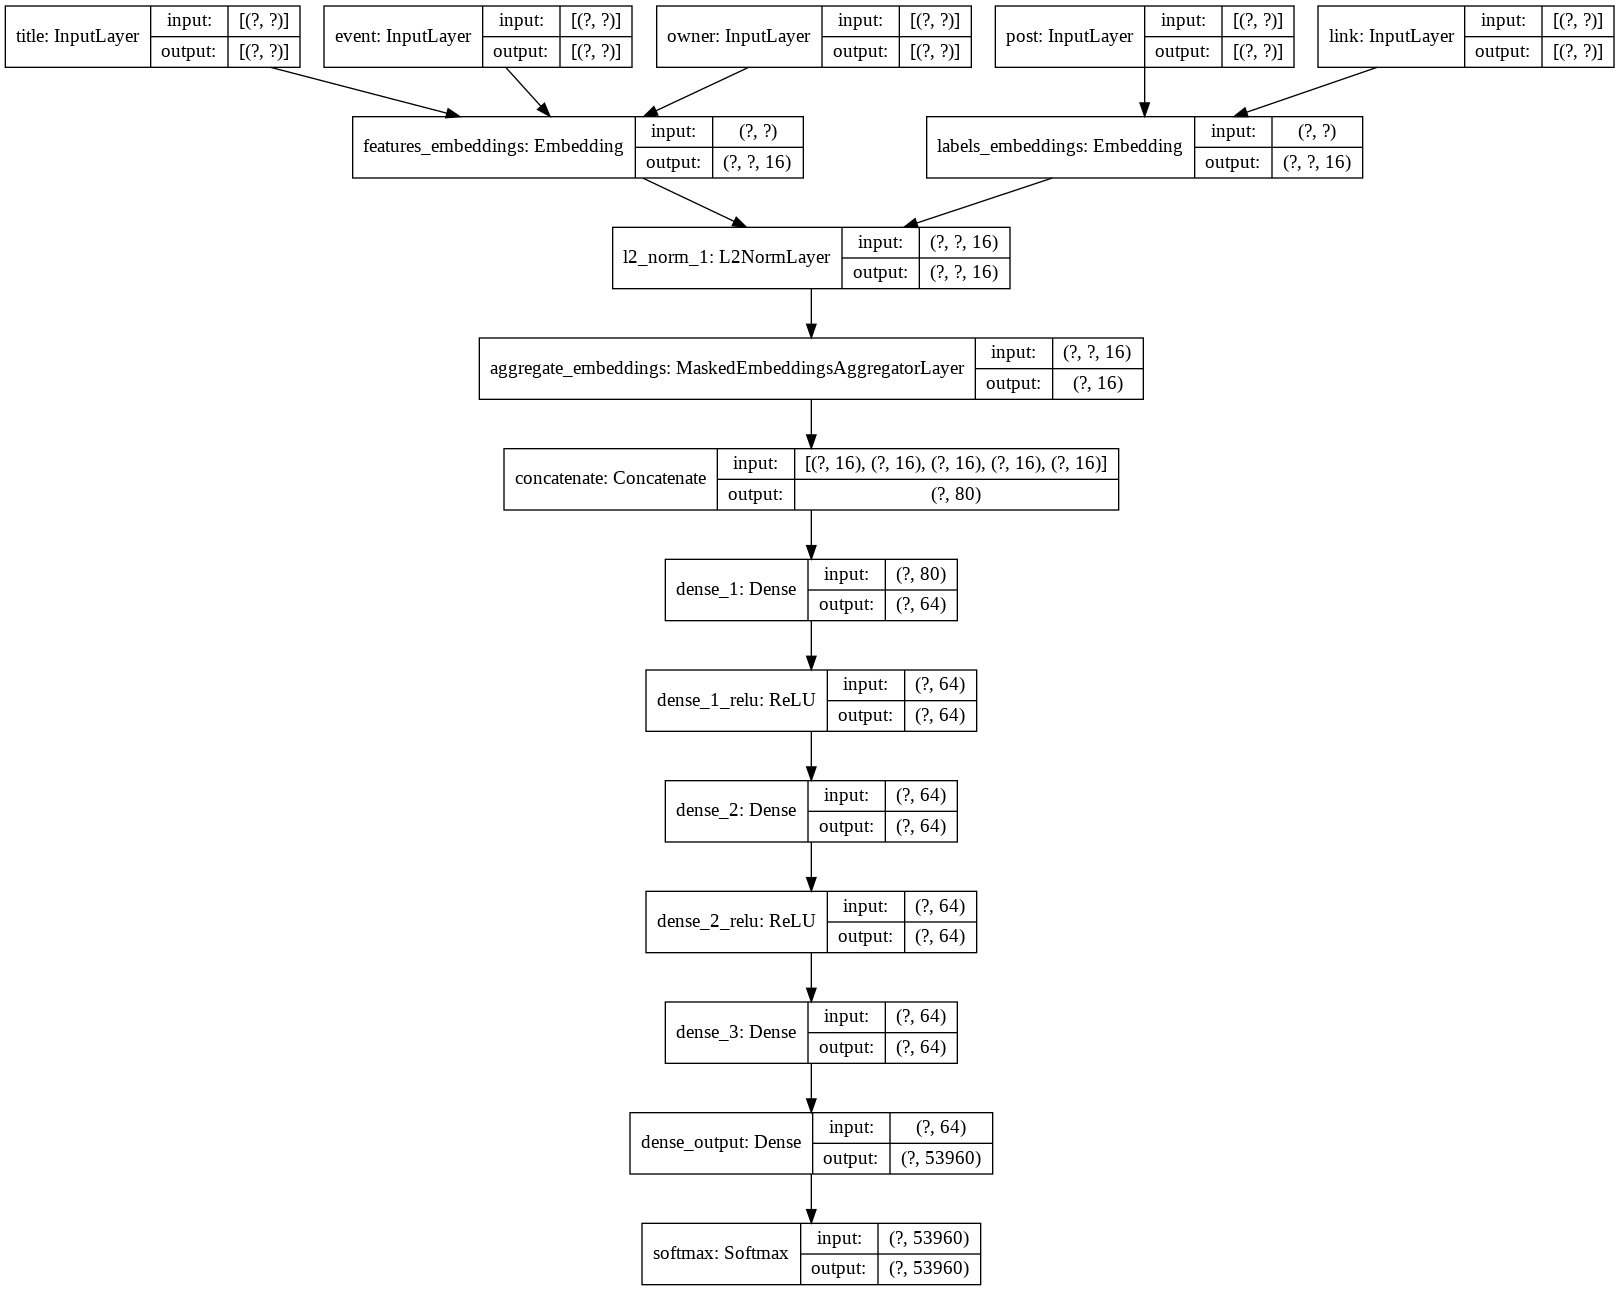

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True,dpi=96)

In [ ]:
model.fit([tf.keras.preprocessing.sequence.pad_sequences(user_list_train['title_d']),
           tf.keras.preprocessing.sequence.pad_sequences(user_list_train['post']),
           tf.keras.preprocessing.sequence.pad_sequences(user_list_train['link_d']),
           tf.keras.preprocessing.sequence.pad_sequences(user_list_train['owner'])
           ,
            tf.keras.preprocessing.sequence.pad_sequences(user_list_train['event'])
           ],user_list_train['predict_labels'].values,
           steps_per_epoch=100, epochs=30,verbose=1)

Epoch 1/30
100/100 [==============================] - 36s 363ms/step - loss: 9.0576
Epoch 2/30
100/100 [==============================] - 36s 360ms/step - loss: 7.9138
Epoch 3/30
100/100 [==============================] - 36s 360ms/step - loss: 7.8564
Epoch 4/30
100/100 [==============================] - 36s 361ms/step - loss: 7.8407
Epoch 5/30
100/100 [==============================] - 36s 357ms/step - loss: 7.8319
Epoch 6/30
100/100 [==============================] - 36s 361ms/step - loss: 7.8267
Epoch 7/30
100/100 [==============================] - 36s 363ms/step - loss: 7.8243
Epoch 8/30
100/100 [==============================] - 36s 362ms/step - loss: 7.8196
Epoch 9/30
100/100 [==============================] - 36s 361ms/step - loss: 7.8172
Epoch 10/30
100/100 [==============================] - 36s 363ms/step - loss: 7.8150
Epoch 11/30
100/100 [==============================] - 36s 356ms/step - loss: 7.8128
Epoch 12/30
100/100 [==============================] - 35s 354ms/step - lo

In [ ]:
user_list_test=user_list[user_list.index>57600]

In [ ]:
model.save('./model')


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model/assets


In [ ]:

predict =model.predict([tf.keras.preprocessing.sequence.pad_sequences(user_list_test['title_d']),
           tf.keras.preprocessing.sequence.pad_sequences(user_list_test['post']),
           tf.keras.preprocessing.sequence.pad_sequences(user_list_test['link_d']),
           tf.keras.preprocessing.sequence.pad_sequences(user_list_test['owner'])
           ,
            tf.keras.preprocessing.sequence.pad_sequences(user_list_test['event'])])


In [ ]:
import numpy as np
predictions = np.array([np.argmax(a) for a in predict])

In [ ]:
user_list_test['predicted_label'] = predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
tf.nn.top_k(
    predict,
    k=20,
    sorted=True,
    name=None
)

TopKV2(values=<tf.Tensor: shape=(14766, 20), dtype=float32, numpy=
array([[0.01841334, 0.01655146, 0.01577927, ..., 0.00619727, 0.00588295,
        0.00584948],
       [0.01841334, 0.01655146, 0.01577927, ..., 0.00619727, 0.00588295,
        0.00584948],
       [0.01841334, 0.01655146, 0.01577927, ..., 0.00619727, 0.00588295,
        0.00584948],
       ...,
       [0.01841334, 0.01655146, 0.01577927, ..., 0.00619727, 0.00588295,
        0.00584948],
       [0.01841334, 0.01655146, 0.01577927, ..., 0.00619727, 0.00588295,
        0.00584948],
       [0.01841334, 0.01655146, 0.01577927, ..., 0.00619727, 0.00588295,
        0.00584948]], dtype=float32)>, indices=<tf.Tensor: shape=(14766, 20), dtype=int32, numpy=
array([[  7,  41, 143, ..., 709, 198,  68],
       [  7,  41, 143, ..., 709, 198,  68],
       [  7,  41, 143, ..., 709, 198,  68],
       ...,
       [  7,  41, 143, ..., 709, 198,  68],
       [  7,  41, 143, ..., 709, 198,  68],
       [  7,  41, 143, ..., 709, 198,  68]], dty

In [ ]:
predict.shape

(14766, 53960)

In [ ]:
features_embedding_layer.get_weights()[0]

array([[-0.0354876 ,  0.04980022, -0.01526859, ...,  0.03380087,
        -0.0034585 , -0.03214854],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [ 0.00264645,  0.01601419, -0.03498159, ...,  0.00932652,
         0.02638849, -0.01251247],
       [ 0.00771867,  0.03992322,  0.01093857, ...,  0.03665196,
         0.0420526 ,  0.03571228],
       [ 0.01108722, -0.02315505, -0.01517798, ..., -0.01094431,
         0.01622495,  0.00342426]], dtype=float32)

In [ ]:
dense_output.get_weights()[0].transpose()

array([[ 0.19646135, -0.20005512,  0.20962179, ...,  0.18949145,
        -0.21450858,  0.20756754],
       [-0.55546284,  0.57903045, -0.6041336 , ..., -0.47148392,
         0.63092846, -0.5846    ],
       [ 0.33453137, -0.3389936 ,  0.33215496, ...,  0.30778083,
        -0.36672693,  0.3378657 ],
       ...,
       [-0.5592768 ,  0.5853029 , -0.60694766, ..., -0.45537406,
         0.6272126 , -0.5819403 ],
       [-0.5574256 ,  0.58276266, -0.601913  , ..., -0.46426016,
         0.6376938 , -0.5828674 ],
       [-0.55511045,  0.5879679 , -0.6115303 , ..., -0.45868003,
         0.62384325, -0.5893937 ]], dtype=float32)

In [ ]:
import io
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
#weights =model.layers[4].get_weights()[0]
#weights = features_embedding_layer.get_weights()[0][1:]
weights = dense_output.get_weights()[0].transpose()


for num, word in enumerate(post2post_encoded):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(str(word) + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [ ]:
weights.shape

(53959, 16)

In [ ]:
len(list(user2user_encoded))

115191